# Introducción al Machine Learning con Python
## Ejercicio: Reuters Dataset

Para este ejemplo vamos a utilizar NumPy, matplotlib y Keras. Todos estos ya se encuentran disponibles en Google Colaboratory, asique no es necesario instalar nada.

Si quieren seguir el ejemplo de manera local en sus computadoras, les recomendamos utilizar la distribución [Anaconda](https://www.anaconda.com/) como su entorno de Python, para minimizar las complicaciones con la instalación de los paquetes.

Este ejercicio está basado en notebooks de François Chollet disponibles en https://github.com/fchollet/deep-learning-with-python-notebooks.

### Preparación del entorno y datos
En primer lugar vamos a cargar las librerías que necesitamos para el ejemplo:

 * NumPy es la librería de cálculo numérico por excelencia en Python, y se utiliza extensamente en el análisis de datos, machine learning y deep learning.
 * Matplotlib es la librería más utilizada para el graficado de datos y funciones matemáticas.
 * Keras es la librería que nos permite abstraernos de los detalles de bajo nivel de librerías como TensorFlow, Theano y CNTK para trabajar con redes neuronales profundas (y otros modelos de Deep Learning) de manera fácil.
   * Desde `keras.datasets` importamos reuters, el dataset con el que vamos a trabajar este ejemplo.
   * También importamos `layers` y `models`, para poder definir las redes neuronales que queremos entrenar.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import reuters
from keras import layers, models

Using TensorFlow backend.


In [2]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [4]:
len(train_data), len(test_data)

(8982, 2246)

El dataset reuters consiste en un poco más de 11,000 cables de noticias de la agencia de noticias Reuters. Está codificado de manera que cada palabra ha sido reemplazada por un número. Por como cargamos los datos, vamos a manejar un vocabulario compuesto por las 10,000 palabras más comunes, y las palabras que no entren en esta categoría van a ser representadas por un número particular que indica "palabra desconocida".

Si queremos leer los cables, es necesario traducirlos de vuelta a palabras. Esto se puede hacer mediante el indice de palabras del dataset, y definiendo una función que lo recorra de manera inversa:

In [9]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for key, value in word_index.items()])

def decode_newswire(nw):
    return " ".join(reverse_word_index.get(i - 3, "?") for i in nw)

In [10]:
decode_newswire(train_data[0])

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

Una vez cargados los datos, es necesario codificarlos de manera adecuada para que la red neuronal los pueda trabajar. Una de las formas de hacer esto es definiendo dos funciones, una para vectorizar los datos de entrada, y otra para codificar la categoría de cada cable:

In [13]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

La función `vectorize_sequences` se usa para codificar el texto de los cables mediante una representación conocida como _bag of words_. Cada vector resultante tiene 10,000 elementos, con valor 0 o 1 y de esta manera se indica la presencia de una palabra en el cable.

La función `to_one_hot` se ocupa de codificar las etiquetas, y genera un vector de 46 elementos donde todos tienen valor 0, excepto la categoría a la cual corresponde la noticia del cable. La función `to_one_hot` es equivalente a `keras.utils.to_categorical`. Si bien en general lo mejor es utilizar las funciones estandarizadas de la librería, para que el ejercicio sea lo más claro posible se optó por definirla en el notebook y poder ver su funcionamiento.

Una vez definidas estas funciones, debemos convertir los datos a estas representaciones:

In [14]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

Además de codificar los datos, muchas veces es útil separar el conjunto de entrenamiento en dos: un conjunto de entrenamiento parcial, y un conjunto de validación. Hay distintas estrategias de validación, pero por la cantidad de datos que tenemos disponibles en este caso vamos a adoptar la más simple: simplemente separar un conjunto de los datos de entrenamiento.

In [17]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]A

### Definir el modelo
Ahora que cargamos los datos, es necesario definir el modelo o la arquitectura de la red neuronal que utilizaremos. Para simplificar la experimentación y las pruebas, vamos a definir una función que nos va a devolver un nuevo modelo, listo para entrenar:

In [18]:
def get_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation="relu", input_shape=(10000,)))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(46, activation="softmax"))
    model.compile(optimizer="rmsprop",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

Veamos en detalle las acciones y decisiones que se tomaron para este modelo inicial:
 * En primer lugar, definimos que el modelo es secuencial, es decir, que las capas del mismo se suceden una a continuación de la otra.
 * Luego agregamos la primer capa, 64 neuronas con función de activación tipo ReLU. Dado que es la primer capa del modelo, debemos especificar el la forma de las neuronas de entrada indicandolo con la tupla `(10000,)`, es decir, la primer capa del modelo espera un vector de 10,000 elementos de largo.
 * Luego agregamos otra capa con 64 neuronas y activación ReLU. Keras ya no necesita que le indiquemos el `input_shape`, puede derivarlo de la capa anterior de manera automática.
 * La última capa la definimos con 46 neuronas y función de activación softmax. Esta función de activación representa una función de densidad de probabilidad entre todas sus neuronas, que les da un valor entre 0 y 1, y se asegura que todas sumen 1 entre sí.
 * En último lugar, compilamos el modelo con los siguientes parámetros:
   * El optimizador `rmsprop` es estándar y funciona bien para el entrenamiento de redes neuronales. Otros optimizadores disponibles son `sgd`, `adadelta`, `adam`, `adamax`, y `nadam`.
   * La función de error o loss que elegimos es `categorical_crossentropy`, que es la función adecuada para el caso de clasificación multicategoría que estamos tratando de resolver.
   * Indicamos que sólo nos interesa seguir una métrica en el proceso de entrenamiento, la precisión (accuracy) del modelo.

Ahora sólo nos resta entrenar el modelo con los datos de entrenamiento parcial y validación, para detectar cómo se comporta y cuál va a ser el punto de entrenamiento óptimo para los datos que tenemos:

In [19]:
model = get_model()
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val),
)

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 9s 1ms/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7208 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 1s 170us/step - loss: 1.4452 - acc: 0.6879 - val_loss: 1.3459 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 2s 191us/step - loss: 1.0953 - acc: 0.7651 - val_loss: 1.1708 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s 169us/step - loss: 0.8697 - acc: 0.8165 - val_loss: 1.0793 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 1s 173us/step - loss: 0.7034 - acc: 0.8472 - val_loss: 0.9844 - val_acc: 0.7810
Epoch 6/20
7982/7982 [==============================] - 2s 203us/step - loss: 0.5667 - acc: 0.8802 - val_loss: 0.9411 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 1s 175us/step - loss: 0.4581 - acc: 0.9048 - val_loss: 0.9083 - val_acc: 0.8020
Ep

El objeto `history` tiene toda la información del entrenamiento en cada época. Vamos a utilizarlo para poder ver gráficamente cómo se fue comportando el entrenamiento, y poder detectar en qué época nos conviene detenerlo para que nuestro modelo se comporte de la mejor manera posible:

In [28]:
def draw_history(history):
    h = history.history
    epochs = range(1, len(h["loss"]) + 1)
    plt.figure(1, figsize=(16, 16))
    plt.clf()
    # primer gráfico
    plt.subplot(221)
    plt.plot(epochs, h["loss"], "bo", label="Error del entrenamiento")
    plt.plot(epochs, h["val_loss"], "b", label="Error de validación")
    plt.xlabel("Épocas")
    plt.ylabel("Error")
    plt.legend()
    # segundo gráfico
    plt.subplot(222)
    plt.plot(epochs, h["acc"], "bo", label="Precisión del entrenamiento")
    plt.plot(epochs, h["val_acc"], "b", label="Precisión de validación")
    plt.xlabel("Épocas")
    plt.ylabel("Preicisión")
    plt.legend()
    # ahora mostramos todo junto
    plt.show()

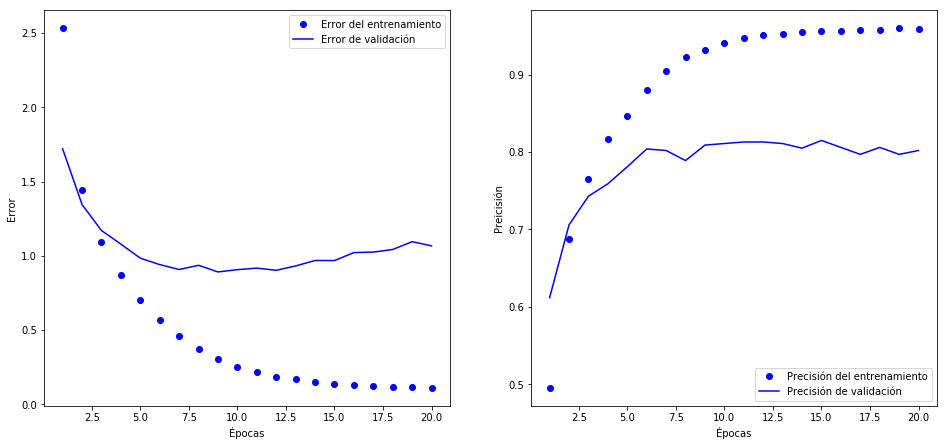

In [29]:
draw_history(history)